# Détection de Fraude - Experiment Tracking avec Plusieurs Modèles
## Azure ML + MLflow - Comparaison de Versions

**Objectif**: Entraîner et comparer plusieurs versions de modèles de détection de fraude

**Modèles testés**:
1. Random Forest (baseline)
2. Random Forest (optimisé)
3. XGBoost
4. LightGBM

---

## 1. Configuration et Imports

In [20]:
pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn mlflow joblib xgboost lightgbm azureml-core


Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Azure ML
from azureml.core import Workspace, Experiment, Run
from azureml.core.model import Model

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, accuracy_score
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Algorithmes avancés
import xgboost as xgb
import lightgbm as lgb

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

import joblib

print("✅ Bibliothèques importées avec succès")

✅ Bibliothèques importées avec succès


## 2. Connexion Azure ML

In [22]:
# Connexion au workspace
try:
    ws = Workspace.from_config()
    print(f"✅ Connecté au workspace: {ws.name}")
except:
    ws = Workspace(
        subscription_id='<VOTRE_SUBSCRIPTION_ID>',
        resource_group='<VOTRE_RESOURCE_GROUP>',
        workspace_name='<VOTRE_WORKSPACE_NAME>'
    )
    print(f"✅ Connecté au workspace: {ws.name}")

# Créer l'expérience principale
experiment_name = 'fraud-detection-model-comparison'
experiment = Experiment(workspace=ws, name=experiment_name)
print(f"✅ Expérience créée: {experiment_name}")

✅ Connecté au workspace: credit-fraud-ml
✅ Expérience créée: fraud-detection-model-comparison


## 3. Chargement et Préparation des Données

In [23]:
pip install azureml-dataset-runtime --upgrade

Note: you may need to restart the kernel to use updated packages.


{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
✅ Données chargées: 6,362,620 lignes, 11 colonnes

Taux de fraude: 0.1291%


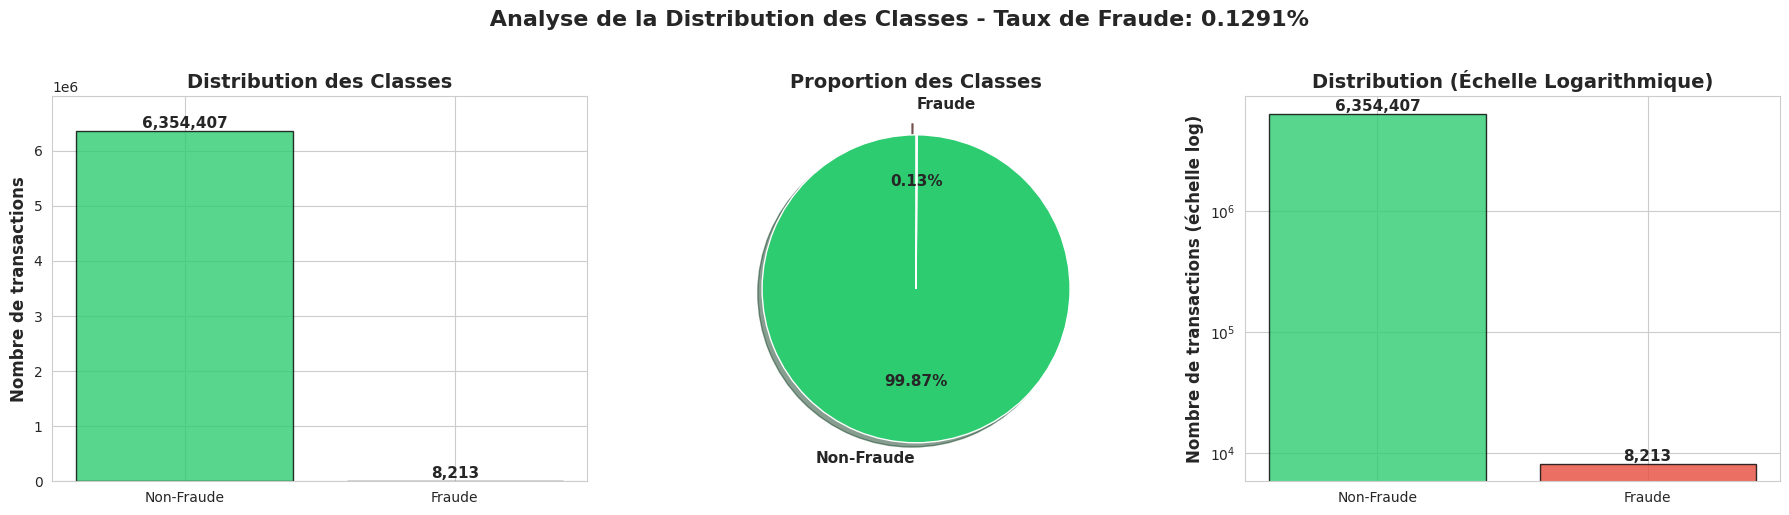


📊 RÉSUMÉ DE LA DISTRIBUTION
            Classe    Nombre Pourcentage
Non-Fraude (False) 6,354,407      99.87%
     Fraude (True)     8,213       0.13%


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,True,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,False,False
1,True,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,False,False
2,True,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,True,False
3,True,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,True,False
4,True,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,False,False


In [24]:
# Charger les données
from azureml.core import Workspace, Dataset, Datastore
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuration du style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

datastore = Datastore.get(ws, datastore_name='workspaceblobstore')

dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, 'fraud_dataset.csv')]
)

df = dataset.to_pandas_dataframe()
print(f"✅ Données chargées: {df.shape[0]:,} lignes, {df.shape[1]} colonnes")

# Calculer les statistiques
class_counts = df['isFraud'].value_counts()
fraud_rate = df['isFraud'].mean() * 100

print(f"\nTaux de fraude: {fraud_rate:.4f}%")

# Créer une figure avec 3 sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Graphique en barres
axes[0].bar(['Non-Fraude', 'Fraude'], 
            [class_counts[False], class_counts[True]], 
            color=['#2ecc71', '#e74c3c'],
            alpha=0.8,
            edgecolor='black')
axes[0].set_ylabel('Nombre de transactions', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution des Classes', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, max(class_counts) * 1.1)

# Ajouter les valeurs sur les barres
for i, (label, count) in enumerate(zip(['Non-Fraude', 'Fraude'], 
                                         [class_counts[False], class_counts[True]])):
    axes[0].text(i, count, f'{count:,}', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Camembert (Pie chart)
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)  # "exploser" la tranche de fraude pour la mettre en évidence

axes[1].pie([class_counts[False], class_counts[True]], 
           labels=['Non-Fraude', 'Fraude'],
           autopct='%1.2f%%',
           startangle=90,
           colors=colors,
           explode=explode,
           shadow=True,
           textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Proportion des Classes', fontsize=14, fontweight='bold')

# 3. Graphique en barres logarithmique pour mieux voir la différence
axes[2].bar(['Non-Fraude', 'Fraude'], 
            [class_counts[False], class_counts[True]], 
            color=['#2ecc71', '#e74c3c'],
            alpha=0.8,
            edgecolor='black')
axes[2].set_yscale('log')
axes[2].set_ylabel('Nombre de transactions (échelle log)', fontsize=12, fontweight='bold')
axes[2].set_title('Distribution (Échelle Logarithmique)', fontsize=14, fontweight='bold')

# Ajouter les valeurs
for i, (label, count) in enumerate(zip(['Non-Fraude', 'Fraude'], 
                                         [class_counts[False], class_counts[True]])):
    axes[2].text(i, count, f'{count:,}', 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# Ajouter un titre général
fig.suptitle(f' Analyse de la Distribution des Classes - Taux de Fraude: {fraud_rate:.4f}%', 
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('fraud_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Afficher aussi un résumé sous forme de tableau
print("\n" + "="*50)
print("📊 RÉSUMÉ DE LA DISTRIBUTION")
print("="*50)

summary_df = pd.DataFrame({
    'Classe': ['Non-Fraude (False)', 'Fraude (True)'],
    'Nombre': [f"{class_counts[False]:,}", f"{class_counts[True]:,}"],
    'Pourcentage': [f"{(class_counts[False]/len(df))*100:.2f}%", 
                    f"{(class_counts[True]/len(df))*100:.2f}%"]
})

print(summary_df.to_string(index=False))
print("="*50)

# Afficher les premières lignes
df.head()

In [25]:
print("🔧 Feature Engineering en cours...")

# One-hot encoding
df = pd.get_dummies(df, columns=['type'], prefix='type', drop_first=False)

# Sécurité : éviter divisions dangereuses
EPS = 1e-6

df['balanceChange_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceChange_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

df['amountToBalanceRatio_orig'] = df['amount'] / (df['oldbalanceOrg'] + EPS)

df['isOriginEmpty'] = (df['oldbalanceOrg'] == 0).astype(int)
df['isDestEmpty'] = (df['oldbalanceDest'] == 0).astype(int)

df['errorBalanceOrig'] = df['balanceChange_orig'] - df['amount']
df['errorBalanceDest'] = df['balanceChange_dest'] - df['amount']

# Nettoyage final : remplacer inf par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Supprimer colonnes non nécessaires
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'], errors='ignore')

print(f"✅ Feature Engineering complété - {df.shape[1]} features")


🔧 Feature Engineering en cours...
✅ Feature Engineering complété - 19 features


In [26]:
# Séparation X/y
X = df.drop('isFraud', axis=1)
y = df['isFraud']
feature_names = X.columns.tolist()

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

Features (X): (6362620, 18)
Target (y): (6362620,)


In [27]:
# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape[0]:,} transactions")
print(f"Test set: {X_test.shape[0]:,} transactions")

Train set: 5,090,096 transactions
Test set: 1,272,524 transactions


In [28]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


In [29]:
# Normalisation après imputation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)

print("✅ Données normalisées")


✅ Données normalisées


In [30]:
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

X_train_balanced, y_train_balanced = over.fit_resample(X_train_scaled, y_train)
X_train_balanced, y_train_balanced = under.fit_resample(
    X_train_balanced, y_train_balanced
)

print("✅ Rééquilibrage réussi")
print(pd.Series(y_train_balanced).value_counts())


✅ Rééquilibrage réussi
isFraud
False    3177203
True     2541763
Name: count, dtype: int64


## 4. Fonction Utilitaire pour l'Experiment Tracking

In [31]:
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, run):
    """
    Entraîne un modèle et log toutes les métriques dans Azure ML
    
    Args:
        model: Le modèle à entraîner
        model_name: Nom du modèle pour le tracking
        X_train, y_train: Données d'entraînement
        X_test, y_test: Données de test
        run: Azure ML Run object
    
    Returns:
        dict: Métriques de performance
    """
    print(f"\n{'='*70}")
    print(f"🚀 Entraînement: {model_name}")
    print(f"{'='*70}")
    
    # Entraînement
    start_time = datetime.now()
    model.fit(X_train, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcul des métriques
    metrics = {
        'model_name': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'training_time_seconds': training_time
    }
    
    # Log des métriques dans Azure ML
    run.log('model_name', model_name)
    run.log('accuracy', metrics['accuracy'])
    run.log('precision', metrics['precision'])
    run.log('recall', metrics['recall'])
    run.log('f1_score', metrics['f1_score'])
    run.log('roc_auc', metrics['roc_auc'])
    run.log('training_time_seconds', training_time)
    
    # Affichage des résultats
    print(f"\n📊 Résultats:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1_score']:.4f}")
    print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"  Temps:     {training_time:.2f}s")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Légal', 'Fraude'],
                yticklabels=['Légal', 'Fraude'])
    plt.title(f'Matrice de Confusion - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.tight_layout()
    
    # Sauvegarder et logger l'image
    img_path = f'confusion_matrix_{model_name.replace(" ", "_")}.png'
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    run.log_image(f'confusion_matrix_{model_name}', plot=plt)
    plt.close()
    
    return metrics, model, y_pred_proba

print("✅ Fonction d'évaluation créée")

✅ Fonction d'évaluation créée


## 5. Experiment Tracking - Entraînement de Plusieurs Modèles

Nous allons entraîner et comparer 4 versions différentes de modèles

In [32]:
from azureml.core import Workspace, Experiment, Run


# Définir un nom fixe pour l'experiment
experiment_name = "FraudDetection--Experiment" 
experiment = Experiment(workspace=ws, name=experiment_name)

# Démarrer le run parent
parent_run = experiment.start_logging()

# Afficher info
print("\n" + "="*70)
print("🧪 DÉBUT DE L'EXPERIMENT TRACKING")
print("="*70)
print(f"Expérience: {experiment.name}")  
print(f"Run ID: {parent_run.id}")

# 5️⃣ Dictionnaires pour stocker les résultats et modèles
all_results = []
all_models = {}



🧪 DÉBUT DE L'EXPERIMENT TRACKING
Expérience: FraudDetection-Experiment
Run ID: b06174ab-24c3-40c3-9570-34cb64afd480


### Modèle 1: Random Forest (Baseline)

In [33]:
# Child run 1
child_run_1 = parent_run.child_run(name="RF_Baseline")

model_1 = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Log des hyperparamètres
child_run_1.log('n_estimators', 50)
child_run_1.log('max_depth', 10)
child_run_1.log('algorithm', 'RandomForest')

metrics_1, trained_model_1, proba_1 = train_and_evaluate_model(
    model_1, 'Random Forest (Baseline)', 
    X_train_balanced, y_train_balanced, 
    X_test_scaled, y_test,
    child_run_1
)

all_results.append(metrics_1)
all_models['RF_Baseline'] = trained_model_1
child_run_1.complete()
print("✅ Modèle 1 complété")


🚀 Entraînement: Random Forest (Baseline)

📊 Résultats:
  Accuracy:  0.9998
  Precision: 0.8779
  Recall:    0.9982
  F1-Score:  0.9342
  ROC-AUC:   0.9997
  Temps:     210.23s
✅ Modèle 1 complété


### Modèle 2: Random Forest (Optimisé)

In [34]:
# Child run 2
child_run_2 = parent_run.child_run(name="RF_Optimized")

model_2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

child_run_2.log('n_estimators', 100)
child_run_2.log('max_depth', 20)
child_run_2.log('min_samples_split', 10)
child_run_2.log('min_samples_leaf', 5)
child_run_2.log('algorithm', 'RandomForest')

metrics_2, trained_model_2, proba_2 = train_and_evaluate_model(
    model_2, 'Random Forest (Optimisé)', 
    X_train_balanced, y_train_balanced, 
    X_test_scaled, y_test,
    child_run_2
)

all_results.append(metrics_2)
all_models['RF_Optimized'] = trained_model_2
child_run_2.complete()
print("✅ Modèle 2 complété")


🚀 Entraînement: Random Forest (Optimisé)

📊 Résultats:
  Accuracy:  0.9998
  Precision: 0.8691
  Recall:    0.9982
  F1-Score:  0.9292
  ROC-AUC:   0.9995
  Temps:     450.36s
✅ Modèle 2 complété


### Modèle 3: XGBoost

In [35]:
# Child run 3
child_run_3 = parent_run.child_run(name="XGBoost")

# Calculer le scale_pos_weight pour gérer le déséquilibre
scale_pos_weight = (y_train_balanced == 0).sum() / (y_train_balanced == 1).sum()

model_3 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

child_run_3.log('n_estimators', 100)
child_run_3.log('max_depth', 6)
child_run_3.log('learning_rate', 0.1)
child_run_3.log('scale_pos_weight', scale_pos_weight)
child_run_3.log('algorithm', 'XGBoost')

metrics_3, trained_model_3, proba_3 = train_and_evaluate_model(
    model_3, 'XGBoost', 
    X_train_balanced, y_train_balanced, 
    X_test_scaled, y_test,
    child_run_3
)

all_results.append(metrics_3)
all_models['XGBoost'] = trained_model_3
child_run_3.complete()
print("✅ Modèle 3 complété")


🚀 Entraînement: XGBoost

📊 Résultats:
  Accuracy:  0.9995
  Precision: 0.7163
  Recall:    0.9976
  F1-Score:  0.8339
  ROC-AUC:   0.9997
  Temps:     29.61s
✅ Modèle 3 complété


### Modèle 4: LightGBM

In [36]:
# Child run 4
child_run_4 = parent_run.child_run(name="LightGBM")

model_4 = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

child_run_4.log('n_estimators', 100)
child_run_4.log('max_depth', 6)
child_run_4.log('learning_rate', 0.1)
child_run_4.log('num_leaves', 31)
child_run_4.log('algorithm', 'LightGBM')

metrics_4, trained_model_4, proba_4 = train_and_evaluate_model(
    model_4, 'LightGBM', 
    X_train_balanced, y_train_balanced, 
    X_test_scaled, y_test,
    child_run_4
)

all_results.append(metrics_4)
all_models['LightGBM'] = trained_model_4
child_run_4.complete()
print("✅ Modèle 4 complété")


🚀 Entraînement: LightGBM
[LightGBM] [Info] Number of positive: 2541763, number of negative: 3177203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.333558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2643
[LightGBM] [Info] Number of data points in the train set: 5718966, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

📊 Résultats:
  Accuracy:  0.9998
  Precision: 0.8751
  Recall:    0.9982
  F1-Score:  0.9326
  ROC-AUC:   0.9997
  Temps:     29.80s
✅ Modèle 4 complété


## 6. Comparaison des Résultats de Tous les Modèles

In [38]:
# Sauvegarder le tableau de comparaison
comparison_df.to_csv('model_comparison.csv', index=False)
parent_run.upload_file('model_comparison.csv', 'model_comparison.csv')
print("✅ Tableau de comparaison sauvegardé")

✅ Tableau de comparaison sauvegardé


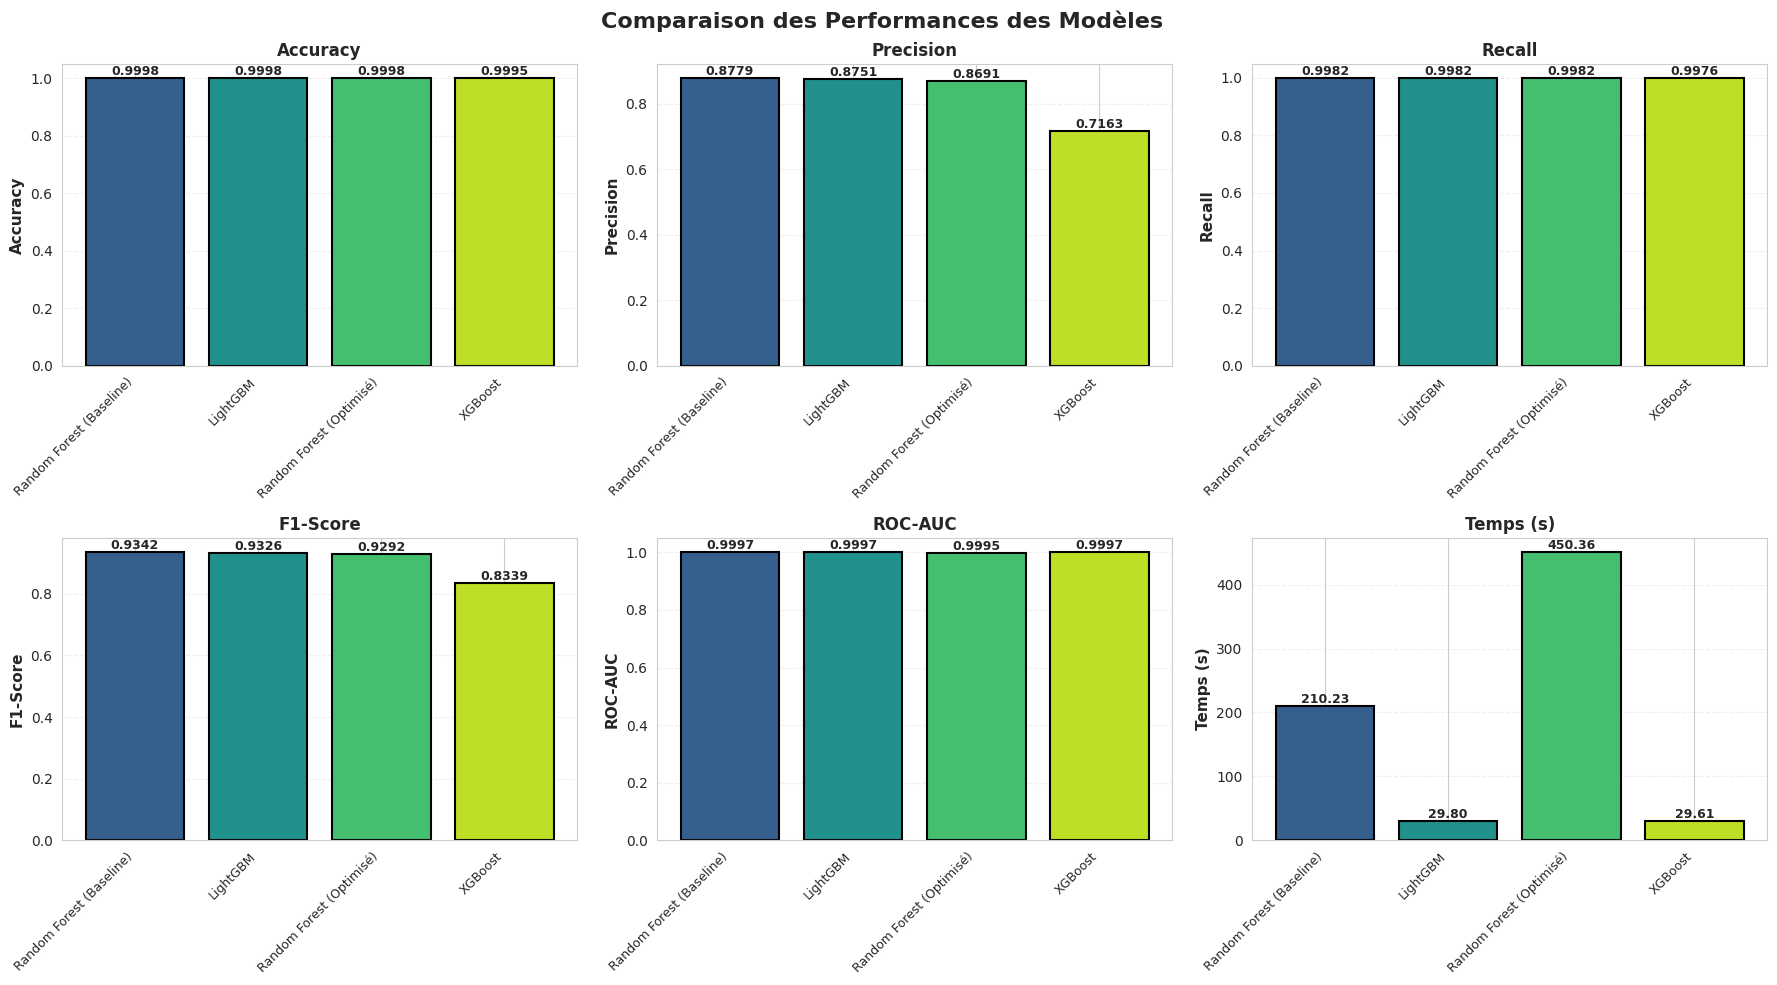

✅ Graphiques de comparaison créés


In [39]:
# Visualisation comparative - Graphique en barres
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparaison des Performances des Modèles', fontsize=16, fontweight='bold')

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'training_time_seconds']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Temps (s)']

for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Extraire les valeurs
    models = comparison_df['model_name'].values
    values = comparison_df[metric].values
    
    # Créer le graphique
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(models)))
    bars = ax.bar(range(len(models)), values, color=colors, edgecolor='black', linewidth=1.5)
    
    # Ajouter les valeurs sur les barres
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}' if metric != 'training_time_seconds' else f'{val:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(name, fontsize=11, fontweight='bold')
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('model_comparison_bars.png', dpi=300, bbox_inches='tight')
parent_run.log_image('model_comparison_bars', plot=plt)
plt.show()

print("✅ Graphiques de comparaison créés")

## 7. Sélection et Enregistrement du Meilleur Modèle

In [40]:
# Identifier le meilleur modèle basé sur le F1-Score
best_model_row = comparison_df.iloc[0]
best_model_name = best_model_row['model_name']

print("\n" + "="*70)
print("🏆 MEILLEUR MODÈLE SÉLECTIONNÉ")
print("="*70)
print(f"\nModèle: {best_model_name}")
print(f"\nPerformances:")
print(f"  - Accuracy:  {best_model_row['accuracy']:.4f}")
print(f"  - Precision: {best_model_row['precision']:.4f}")
print(f"  - Recall:    {best_model_row['recall']:.4f}")
print(f"  - F1-Score:  {best_model_row['f1_score']:.4f}")
print(f"  - ROC-AUC:   {best_model_row['roc_auc']:.4f}")
print("="*70)


🏆 MEILLEUR MODÈLE SÉLECTIONNÉ

Modèle: Random Forest (Baseline)

Performances:
  - Accuracy:  0.9998
  - Precision: 0.8779
  - Recall:    0.9982
  - F1-Score:  0.9342
  - ROC-AUC:   0.9997


In [41]:
# Récupérer le meilleur modèle
model_key = best_model_name.replace(' ', '_').replace('(', '').replace(')', '')
if 'Baseline' in best_model_name:
    best_model = all_models['RF_Baseline']
elif 'Optimisé' in best_model_name:
    best_model = all_models['RF_Optimized']
elif 'Gradient' in best_model_name:
    best_model = all_models['GradientBoosting']
elif 'XGBoost' in best_model_name:
    best_model = all_models['XGBoost']
elif 'LightGBM' in best_model_name:
    best_model = all_models['LightGBM']

# Sauvegarder le meilleur modèle
best_model_filename = 'best_fraud_detection_model.pkl'
joblib.dump(best_model, best_model_filename)
joblib.dump(scaler, 'scaler.pkl')

print(f"✅ Meilleur modèle sauvegardé: {best_model_filename}")

✅ Meilleur modèle sauvegardé: best_fraud_detection_model.pkl


In [46]:
# Enregistrer dans Azure ML
parent_run.upload_file(name='fraud-app/outputs/' + best_model_filename, path_or_stream=best_model_filename)
parent_run.upload_file(name='fraud-app/outputs/scaler.pkl', path_or_stream='scaler.pkl')

# Enregistrer comme modèle Azure ML
registered_model = parent_run.register_model(
    model_name='fraud-detection-best',
    model_path='fraud-app/outputs/' + best_model_filename,
    description=f'Best fraud detection model: {best_model_name}',
    tags={
        'algorithm': best_model_name,
        'accuracy': f"{best_model_row['accuracy']:.4f}",
        'f1_score': f"{best_model_row['f1_score']:.4f}",
        'roc_auc': f"{best_model_row['roc_auc']:.4f}",
        'experiment': experiment_name
    }
)

print(f"✅ Modèle enregistré dans Azure ML: {registered_model.name}, Version: {registered_model.version}")

✅ Modèle enregistré dans Azure ML: fraud-detection-best, Version: 3


In [43]:
# Enregistrer tous les modèles individuellement
print("\n📦 Enregistrement de tous les modèles...")

for idx, row in comparison_df.iterrows():
    model_name = row['model_name']
    model_key = model_name.replace(' ', '_').replace('(', '').replace(')', '')
    
    if 'Baseline' in model_name:
        model = all_models['RF_Baseline']
    elif 'Optimisé' in model_name:
        model = all_models['RF_Optimized']
    elif 'Gradient' in model_name:
        model = all_models['GradientBoosting']
    elif 'XGBoost' in model_name:
        model = all_models['XGBoost']
    elif 'LightGBM' in model_name:
        model = all_models['LightGBM']
    
    filename = f"model_{model_key}.pkl"
    joblib.dump(model, filename)
    print(f"  ✓ {model_name} sauvegardé")

print("\n✅ Tous les modèles ont été enregistrés")


📦 Enregistrement de tous les modèles...
  ✓ Random Forest (Baseline) sauvegardé
  ✓ LightGBM sauvegardé
  ✓ Random Forest (Optimisé) sauvegardé
  ✓ XGBoost sauvegardé

✅ Tous les modèles ont été enregistrés


In [44]:
# Terminer le run parent
parent_run.complete()
print("\n✅ Expérience Azure ML terminée")


✅ Expérience Azure ML terminée


## 8. Export pour Power BI

In [45]:
# Export du tableau de comparaison pour Power BI
comparison_df.to_csv('model_comparison_powerbi.csv', index=False)

# Créer un résumé détaillé
summary_df = comparison_df.copy()
summary_df['rank'] = range(1, len(summary_df) + 1)
summary_df = summary_df[[
    'rank', 'model_name', 'accuracy', 'precision', 'recall', 
    'f1_score', 'roc_auc', 'training_time_seconds'
]]

summary_df.to_csv('models_detailed_summary.csv', index=False)

print("✅ Fichiers exportés pour Power BI:")
print("   - model_comparison_powerbi.csv")
print("   - models_detailed_summary.csv")

✅ Fichiers exportés pour Power BI:
   - model_comparison_powerbi.csv
   - models_detailed_summary.csv
